In [147]:
import xgboost as xgb

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, mean_squared_error
from pandas.plotting import scatter_matrix
import pickle



In [160]:
nlp_df = pd.read_csv('../data/df_with_nlp.csv', index_col=0)
X = nlp_df
X = X[['culture-values-stars', 'career-opportunities-stars',
                       'comp-benefit-stars', 'senior-management-stars', 'helpful-count',
                       'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter', 'incomplete_review', 'pros_len', 'cons_len']]
y = pd.read_csv("../data/work-balance-stars.csv", header=None, index_col=0).values

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forest

In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100, 200, 500, 1000],
                      'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)
print( "best parameters:", rf_gridsearch.best_params_ )

best_rf_model = rf_gridsearch.best_estimator_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 39.9min finished


best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}


In [104]:
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'random_state': 1}
rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

C:\Users\jq\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [105]:
y_pred = rf.predict(X_test)

In [106]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

1.246871545469176
1.5546886509006912


### Gradient Boosted Regressor

In [162]:
xgb_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, verbose=1, max_depth=3)
xgb_model.fit(X_train, y_train, verbose=1)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [163]:
y_pred = xgb_model.predict(X_test)

In [164]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

0.9076904366093369
0.8239019287120486


In [154]:
for i in range(len(y_test)):
    print(y_test[i], y_pred[i])

[5.] 4.485774
[1.] 1.6456922
[2.] 1.988295
[3.] 3.5962148
[3.] 2.8243108
[5.] 4.020815
[2.] 2.9872496
[4.] 3.031793
[5.] 4.1698833
[4.] 3.971591
[4.] 2.2504764
[1.] 2.2214508
[4.] 3.6498175
[2.] 2.731032
[2.] 3.3674946
[4.] 3.3715048
[5.] 3.6728573
[3.] 2.8802683
[3.] 3.7201366
[2.] 2.2800379
[1.] 2.66994
[2.] 2.335602
[4.] 4.1727276
[4.] 3.7742364
[5.] 3.077493
[3.] 2.9693482
[5.] 4.0997763
[5.] 3.9888759
[3.] 2.3822722
[2.] 3.2102902
[4.] 3.532808
[1.] 2.909857
[2.] 1.6994978
[3.] 3.0384438
[1.] 1.547814
[5.] 4.405635
[3.] 2.8591712
[3.] 4.298344
[3.] 3.7981536
[3.] 3.150667
[3.] 1.1762815
[3.] 3.4679031
[4.] 3.610678
[4.] 3.163322
[2.] 2.8430693
[5.] 4.4553537
[2.] 2.326963
[2.] 1.9738576
[3.] 3.1829302
[2.] 2.7086396
[3.] 3.8755147
[3.] 3.709168
[2.] 2.4647508
[5.] 4.4478955
[5.] 4.543568
[1.] 3.4625869
[1.] 2.086316
[5.] 4.5705123
[3.] 2.6509676
[1.] 1.3030729
[2.] 2.3537436
[4.] 3.5570245
[5.] 3.8451793
[3.] 3.235475
[4.] 3.5563066
[3.] 1.378106
[4.] 3.4448793
[5.] 4.405635
[1.] 

[1.] 2.475224
[5.] 4.543568
[4.] 3.027247
[4.] 3.477527
[3.] 1.98523
[2.] 2.51504
[3.] 2.9018633
[1.] 1.8295707
[4.] 4.5705123
[3.] 2.8791037
[2.] 4.1126575
[3.] 3.1118205
[4.] 3.346346
[3.] 2.8908453
[1.] 2.0740972
[5.] 4.409213
[3.] 3.0158336
[4.] 4.3649035
[2.] 3.0690148
[4.] 3.3574674
[4.] 3.5574198
[1.] 1.5298659
[1.] 2.597798
[1.] 2.103519
[3.] 2.7721198
[3.] 2.2687087
[5.] 3.966631
[4.] 2.8712819
[3.] 2.8390954
[5.] 4.5712104
[3.] 2.7018738
[4.] 3.2849412
[1.] 1.5720831
[3.] 3.0032427
[3.] 2.7370543
[3.] 2.7652993
[5.] 3.5680292
[5.] 4.462714
[4.] 3.0631485
[4.] 2.84814
[5.] 4.4503727
[3.] 3.3371894
[2.] 2.2193873
[3.] 2.750117
[3.] 2.1088157
[2.5] 2.532155
[3.] 3.0072286
[2.] 2.826116
[5.] 4.3703823
[1.] 2.856524
[5.] 4.264723
[2.] 3.606228
[5.] 4.0804224
[2.5] 2.6294496
[4.] 4.1384363
[3.] 2.8198059
[4.] 3.5574198
[3.] 3.0141182
[2.] 2.3692007
[5.] 3.2924154
[2.] 2.1392007
[4.] 2.8405778
[3.] 2.8293731
[4.] 3.944299
[3.] 3.247561
[1.] 3.263478
[3.] 2.851025
[3.] 2.931411
[3.] 

[5.] 4.5705123
[3.] 3.5708666
[4.] 3.235475
[3.] 3.1948018
[4.] 3.5816362
[3.] 2.8749769
[2.] 3.45682
[2.] 2.212824
[5.] 3.0252821
[4.] 3.5816362
[3.] 3.730326
[3.] 3.3527076
[3.5] 3.8091447
[3.] 2.9018633
[3.] 3.0216615
[1.] 1.5159291
[5.] 3.852025
[3.] 2.851025
[2.] 1.9018764
[3.] 3.0366142
[4.] 3.3617363
[3.] 2.4776938
[1.] 2.4443216
[2.] 2.6803284
[5.] 3.6222162
[3.] 3.0690148
[3.] 2.899621
[3.] 2.938811
[1.] 2.9987745
[2.] 2.930371
[4.] 2.4810224
[4.] 4.15493
[2.] 1.2966018
[3.] 2.8291485
[4.] 4.543568
[2.] 1.5440319
[4.] 3.9511964
[3.] 2.9832935
[3.5] 3.2258215
[5.] 2.620406
[4.] 2.9872496
[1.] 2.5237315
[2.] 1.8087679
[3.] 2.8802683
[5.] 3.9439669
[2.] 4.3549013
[2.] 2.718625
[1.] 1.4073288
[4.] 3.204103
[2.] 3.815431
[2.] 1.9404004
[4.] 3.6769474
[1.] 1.2709932
[1.] 2.0194497
[3.] 2.8522286
[3.] 2.8057427
[4.] 2.9983318
[3.] 2.7546892
[5.] 2.9810367
[4.] 4.1727276
[1.] 1.6176196
[4.] 2.3830438
[3.] 3.1875231
[4.] 3.5846376
[4.] 2.8900745
[4.] 3.1165428
[3.] 2.9245293
[2.] 2.905

[2.] 3.0903666
[5.] 3.1413662
[4.] 2.9362538
[3.] 2.973729
[2.] 2.0631528
[5.] 3.7727017
[5.] 4.18408
[1.] 1.9221067
[3.] 2.9271662
[5.] 4.250102
[5.] 4.5637856
[3.] 3.4758139
[2.] 2.3172145
[3.] 2.9103844
[2.] 2.5720422
[3.] 4.1577744
[1.] 1.626762
[3.] 3.2614799
[3.] 2.8139942
[2.] 2.6581063
[2.] 2.6867821
[4.] 3.6515613
[3.] 3.7153444
[4.] 3.3023005
[4.] 3.5574198
[1.] 1.4120736
[5.] 3.8657272
[5.] 3.82237
[3.] 2.9544208
[1.] 1.9758755
[3.] 3.029911
[3.] 4.537641
[4.] 3.4653506
[4.] 3.4511003
[1.] 3.1932273
[3.] 3.558812
[1.] 2.4314134
[1.] 2.3829532
[3.] 2.743512
[3.] 2.754846
[5.] 4.5705123
[2.] 2.4504793
[4.] 2.2571392
[3.] 3.16033
[3.] 3.0961752
[2.] 2.637995
[5.] 3.464099
[1.] 1.5977244
[4.] 3.5963686
[4.] 3.9623988
[3.] 4.453013
[4.] 3.7592905
[2.] 2.3702016
[2.] 2.909857
[3.] 2.9018633
[3.] 2.9315562
[1.] 1.6005185
[1.] 2.5458608
[2.] 1.6328733
[3.] 3.0644932
[1.] 1.4536364
[3.] 3.0072286
[4.] 3.2656395
[1.] 1.1402292
[3.] 2.931411
[3.] 3.4972925
[4.] 3.9476922
[2.] 3.0000286

[1.] 1.8732934
[1.] 1.9318495
[3.] 3.0286005
[2.] 2.068522
[1.] 3.1179233
[3.] 2.9832935
[3.] 2.2184255
[2.] 2.8890624
[4.] 3.8156254
[3.] 2.5611691
[3.] 4.2489033
[3.] 3.370585
[4.] 3.1193907
[5.] 4.543568
[2.] 1.6476574
[4.] 3.8235705
[2.] 3.1569686
[4.] 4.1577744
[2.] 2.6740963
[1.] 1.6626751
[3.] 2.9018633
[1.5] 3.1081622
[4.] 2.921199
[3.] 1.8378918
[3.] 1.2578197
[3.] 3.532624
[4.] 3.726458
[1.] 2.0370288
[1.] 1.429046
[1.] 1.5534501
[3.] 2.3104987
[3.] 1.5035765
[2.] 3.7864223
[3.] 2.9832935
[2.] 2.937629
[4.] 3.5563066
[4.] 3.6685514
[3.] 3.0735416
[3.] 4.4898653
[5.] 4.4553537
[5.] 3.8025675
[3.] 1.853372
[5.] 3.532624
[2.] 3.0132987
[3.] 2.8877985
[1.] 3.0072286
[3.] 2.9832935
[2.] 2.7907748
[1.] 2.2490916
[3.] 2.5856688
[3.] 3.752185
[4.] 2.533981
[3.] 3.3318214
[5.] 4.0740623
[1.] 2.674891
[3.] 2.8848903
[4.] 4.5637856
[4.] 2.1889114
[1.] 2.1919818
[3.] 2.973244
[4.] 2.335602
[3.] 2.6099432
[4.] 3.7255576
[1.] 1.7136643
[3.] 2.298203
[2.] 3.9797845
[2.] 2.970085
[3.] 3.1925

[3.] 3.065029
[4.] 3.2336254
[3.] 1.8731256
[3.] 4.392333
[4.] 3.1303422
[3.] 3.9602263
[3.] 2.927082
[4.] 3.0434608
[2.] 3.1054783
[3.] 3.918891
[5.] 3.582386
[4.] 3.297666
[1.] 3.0216615
[2.] 2.2622275
[1.] 2.723831
[5.] 4.042661
[3.] 2.8390954
[5.] 4.5712104
[1.] 1.8266513
[5.] 3.7275174
[3.] 1.4197412
[3.] 2.7594216
[1.] 1.6573725
[4.] 4.5637856
[5.] 3.4269838
[3.] 3.4136643
[4.] 1.9575783
[2.] 2.8817892
[1.] 1.8697665
[5.] 4.5641065
[4.] 4.5705123
[1.] 1.6756175
[2.] 1.5631838
[1.] 1.673447
[3.] 4.4098945
[2.] 2.8841517
[2.] 3.7864223
[3.] 2.7651315
[2.] 3.0180743
[5.] 4.4108114
[4.] 4.066712
[3.5] 3.245908
[3.] 3.514423
[2.] 2.081366
[3.] 3.6112812
[2.] 2.4446197
[3.] 3.5443397
[3.] 2.2085242
[4.] 3.029524
[2.] 1.9023908
[2.] 1.5962744
[5.] 4.036168
[1.] 2.1472316
[5.] 3.918891
[5.] 4.537641
[1.] 1.2360148
[5.] 4.4725165
[5.] 3.8915896
[3.] 2.9544208
[2.] 3.2802691
[3.] 3.1828785
[2.] 2.5205438
[1.] 1.0257392
[3.] 2.1997612
[3.] 2.7461178
[3.] 3.2002077
[3.] 2.8438792
[4.] 2.6004

[3.] 3.0311751
[3.] 3.255954
[3.] 3.0286005
[1.] 1.6154463
[2.] 2.0779586
[3.] 3.2845275
[5.] 4.4731064
[1.] 1.707031
[5.] 2.9594288
[4.] 3.6570067
[4.] 3.4766228
[3.] 2.9446638
[3.] 3.0911
[3.] 2.921799
[1.] 1.3069413
[3.] 2.8241425
[3.] 3.4448793
[3.] 3.0286005
[4.] 2.3837209
[1.] 1.2605286
[3.] 2.8430693
[4.5] 3.9730258
[1.] 1.4120736
[3.] 3.0745614
[4.] 3.0134265
[3.] 2.49363
[1.] 1.529304
[1.] 3.248603
[3.] 3.0104425
[3.] 3.081323
[3.] 3.0141182
[2.] 2.0593152
[4.] 2.9776783
[1.] 1.321449
[3.] 2.656801
[5.] 2.2442203
[2.] 2.086316
[2.] 2.717494
[3.] 4.556681
[2.] 3.4216
[4.] 3.6678183
[4.] 2.9271288
[3.] 2.9939134
[4.] 3.8915896
[1.] 2.1616774
[4.] 2.599408
[4.] 4.172028
[4.] 3.6353304
[5.] 1.6016725
[1.] 1.463584
[2.] 2.1151319
[2.] 3.0904896
[4.] 2.5226462
[2.] 3.5497563
[5.] 4.4205475
[2.] 2.6351953
[3.] 2.7893548
[4.] 3.4644248
[3.] 3.7774844
[3.] 3.605509
[4.] 3.387903
[3.] 3.0141182
[5.] 4.5509644
[2.] 2.4524434
[3.] 2.7714443
[4.] 3.4402084
[2.] 3.299925
[3.] 3.0768385
[5.]

In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(rmse)
print(mse)

0.8723116190562487
0.7609275607405339


In [72]:
with open('models/gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(xgb_model, f)

In [6]:
param_grid = {'max_depth': [3],
              'learning_rate': [0.01],
              'n_estimators': [100, 200, 500, 1000],
              'subsample': [0.5]
              }

gbr_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                             param_grid,
                             n_jobs=-1,
                             verbose=1,
                             scoring='neg_mean_squared_error',
                             cv=3)
gbr_gridsearch.fit(X_train, y_train)
print( "best parameters:", gbr_gridsearch.best_params_ )

best_gbr_model = gbr_gridsearch.best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 22.3min finished


best parameters: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [32]:
best_y_preds = best_gbr_model.predict(X_test)

In [23]:
for i in range(len(y_test)):
    print(y_test[i], best_y_preds[i])

NameError: name 'best_y_preds' is not defined

In [11]:
mse = mean_squared_error(y_test, best_y_preds)
rmse = mse ** 0.5
print(mse)
print(rmse)

1.8738464762673295
1.368885121647295


In [33]:
with open('models/best_gradient_boosting_regressor.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(best_gbr_model, f)

In [73]:
y_pred = gbr.predict(X_test)

In [75]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(mse)
print(rmse)

0.8921436054582954
0.9445335385566229


### RNN

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\jq\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [16]:
timesteps=1

In [6]:
X_train = X_train[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]
X_test = X_test[['culture-values-stars', 'career-opportunities-stars', 'comp-benefit-stars', 'senior-management-stars', 
                   'helpful-count', 'is_current_employee', 'year', 'quarter', 'amazon_earnings_this_quarter','timesteps']]

In [17]:
X_train = X_train.values.reshape(X_train.values.shape[0], timesteps, X_train.values.shape[1])
X_test = X_test.values.reshape(X_test.values.shape[0], timesteps, X_test.values.shape[1])

In [47]:
neurons=50
model = Sequential()
model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=5, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

In [7]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(32, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dropout(0.2))
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 10,849
Trainable params: 10,849
Non-trainable params: 0
_________________________________________________________________


In [8]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(X_train, y_train, epochs=50, batch_size=32, 
             validation_data=(X_test, y_test), verbose=2, shuffle=False, callbacks=callbacks_list)

Train on 17706 samples, validate on 8722 samples
Epoch 1/50
 - 566s - loss: 1.6723 - mean_squared_error: 1.6723 - val_loss: 1.6092 - val_mean_squared_error: 1.6092

Epoch 00001: val_loss improved from inf to 1.60920, saving model to Weights-001--1.60920.hdf5
Epoch 2/50
 - 574s - loss: 1.6334 - mean_squared_error: 1.6334 - val_loss: 1.6094 - val_mean_squared_error: 1.6094

Epoch 00002: val_loss did not improve from 1.60920
Epoch 3/50
 - 580s - loss: 1.6302 - mean_squared_error: 1.6302 - val_loss: 1.6082 - val_mean_squared_error: 1.6082

Epoch 00003: val_loss improved from 1.60920 to 1.60821, saving model to Weights-003--1.60821.hdf5
Epoch 4/50
 - 581s - loss: 1.6277 - mean_squared_error: 1.6277 - val_loss: 1.6068 - val_mean_squared_error: 1.6068

Epoch 00004: val_loss improved from 1.60821 to 1.60678, saving model to Weights-004--1.60678.hdf5
Epoch 5/50
 - 583s - loss: 1.6256 - mean_squared_error: 1.6256 - val_loss: 1.6058 - val_mean_squared_error: 1.6058

Epoch 00005: val_loss improved

In [45]:
y_pred_rnn = NN_model.predict(X_test)

In [37]:
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = mse_rnn ** 0.5
print(mse_rnn)
print(rmse_rnn)

1.602812636013981
1.2660223678963896


In [46]:
for i in range(len(y_test)):
    print(y_test[i], y_pred_rnn[i])

[5.] [3.0441027]
[1.] [3.0004203]
[2.] [2.9751554]
[3.] [3.0191267]
[3.] [2.9931169]
[5.] [2.9972882]
[2.] [3.0112665]
[4.] [3.0047555]
[5.] [2.9921126]
[4.] [2.997701]
[4.] [3.0177186]
[1.] [3.0326993]
[4.] [2.995985]
[2.] [3.0092943]
[2.] [2.9794383]
[4.] [3.0028987]
[5.] [3.0046394]
[3.01421128] [2.9820342]
[3.] [3.0137894]
[2.] [3.0102627]
[1.] [2.9938788]
[2.] [3.0033855]
[4.] [3.017643]
[4.] [2.9784462]
[5.] [3.0121455]
[3.] [3.0122547]
[5.] [3.071879]
[5.] [2.9876974]
[3.] [2.9721355]
[2.] [2.9799862]
[4.] [3.0085244]
[1.] [3.0227585]
[2.] [2.9977946]
[3.] [3.00873]
[1.] [3.0061698]
[5.] [2.9886422]
[3.] [3.0074677]
[3.] [3.0091634]
[3.] [2.9916823]
[3.] [3.0022666]
[3.] [2.9906006]
[3.] [3.0136688]
[4.] [3.0008621]
[4.] [3.0058684]
[2.] [2.9741156]
[5.] [3.0142462]
[2.] [3.0132627]
[2.] [3.0082142]
[3.] [3.0363703]
[2.] [3.0112066]
[3.] [3.0053973]
[3.] [3.0046253]
[2.] [3.0007634]
[5.] [3.00404]
[5.] [3.0047626]
[1.] [3.0154076]
[1.] [3.0108857]
[5.] [3.0101335]
[3.] [3.001402

[3.01421128] [2.9987774]
[3.01421128] [2.998078]
[3.01421128] [2.9797204]
[2.] [2.9782608]
[3.] [3.005476]
[1.] [2.9952815]
[1.] [3.0117168]
[3.] [2.974144]
[1.] [3.0086215]
[4.] [3.0136688]
[3.01421128] [2.979714]
[2.] [3.0086865]
[2.] [2.9750395]
[2.] [2.9716558]
[2.] [3.0059125]
[3.] [2.999667]
[5.] [3.0167546]
[3.01421128] [3.0039062]
[3.] [3.0007608]
[4.5] [3.0020876]
[1.] [2.9703228]
[2.] [3.0018973]
[4.] [2.9942672]
[5.] [2.985847]
[3.01421128] [3.069734]
[3.01421128] [3.0024614]
[2.] [2.9854903]
[1.] [2.985679]
[2.5] [2.9942534]
[5.] [3.017643]
[4.] [3.0121455]
[4.] [3.0025854]
[2.] [3.0118277]
[4.] [3.0149355]
[1.] [3.0106058]
[1.] [3.005049]
[3.] [3.0152555]
[1.] [2.9645243]
[3.] [3.0091834]
[1.] [3.0340376]
[3.] [2.9976194]
[4.] [3.0101829]
[1.] [3.0025735]
[4.] [3.038796]
[4.] [3.016295]
[2.] [3.0083795]
[1.] [3.0046048]
[3.] [2.9979095]
[3.] [2.9836988]
[1.] [3.0118277]
[5.] [3.0314212]
[2.] [2.99755]
[5.] [2.98904]
[2.] [3.013736]
[1.] [2.9762464]
[4.] [2.9823434]
[5.] [3

[5.] [3.0051436]
[2.] [2.9747648]
[4.] [3.0078666]
[2.] [2.9698029]
[2.] [2.998586]
[5.] [3.0126498]
[5.] [3.0112512]
[1.] [2.9692163]
[2.] [2.9764361]
[4.] [3.006844]
[3.] [2.9872007]
[3.01421128] [3.0068398]
[1.] [3.0069146]
[2.] [3.0302444]
[3.] [3.0015898]
[2.] [3.001357]
[1.] [3.0086079]
[3.] [3.009647]
[3.01421128] [2.994833]
[4.] [2.9760044]
[2.] [2.984525]
[5.] [3.0098898]
[2.] [3.0946622]
[4.] [3.0047555]
[4.] [3.0054302]
[3.] [3.0023994]
[3.] [3.0108454]
[5.] [3.0531895]
[2.] [2.986033]
[1.] [2.9727192]
[4.] [3.0307245]
[4.] [3.0218282]
[2.] [3.0080843]
[2.] [2.997847]
[1.] [3.0046253]
[3.01421128] [3.0065784]
[3.] [3.0036979]
[3.] [3.0081577]
[3.01421128] [3.0086079]
[1.] [3.0036364]
[2.] [2.9667463]
[3.] [3.0078616]
[4.] [3.0073164]
[3.] [3.0211234]
[2.] [2.9936619]
[4.] [3.0121708]
[3.5] [3.005049]
[3.01421128] [2.9788616]
[1.] [2.9941611]
[2.] [2.9994442]
[4.] [2.996536]
[3.01421128] [3.1227586]
[4.] [3.0032284]
[3.] [2.9832067]
[3.] [2.984808]
[3.01421128] [3.0370913]
[3

[3.] [2.9816215]
[5.] [2.9954038]
[3.] [3.0032284]
[5.] [3.002635]
[4.] [3.0081916]
[1.] [3.0102253]
[5.] [2.9984536]
[3.01421128] [3.0127048]
[3.] [3.0385046]
[1.] [3.0082889]
[5.] [2.9970996]
[5.] [2.9711535]
[4.] [3.017643]
[2.] [2.9699206]
[1.] [2.976757]
[2.] [3.0152555]
[4.] [3.1051183]
[4.] [3.0005264]
[4.] [3.0177186]
[3.] [3.0003202]
[3.01421128] [2.9996126]
[5.] [3.0005555]
[1.] [2.9787495]
[4.] [2.9918647]
[3.] [3.007382]
[1.] [3.008369]
[3.] [3.0162897]
[4.] [3.0097568]
[2.] [3.0095]
[5.] [3.011475]
[5.] [3.0062869]
[2.] [2.999668]
[4.] [2.9957247]
[5.] [2.997701]
[2.] [3.0086079]
[1.] [3.0121455]
[5.] [3.0063193]
[1.] [2.997302]
[4.] [3.017643]
[1.] [2.993912]
[3.01421128] [2.9758651]
[1.] [3.0005808]
[5.] [2.9990711]
[1.] [3.0162027]
[4.] [3.004516]
[2.] [3.0080554]
[4.] [2.988724]
[1.] [2.979714]
[3.] [3.0090535]
[3.] [2.9996448]
[1.] [3.005073]
[2.] [2.9915566]
[1.] [3.0116913]
[4.] [2.9991264]
[3.] [3.0082371]
[3.] [3.0283222]
[3.] [3.0121455]
[1.] [3.0012665]
[2.] [2.

[4.] [3.0136688]
[4.] [2.9863682]
[2.] [3.0061517]
[2.] [3.0152555]
[2.] [2.976139]
[3.] [3.0051436]
[3.] [3.0017161]
[4.] [3.0044556]
[3.01421128] [2.9897833]
[2.] [2.9823434]
[3.] [2.9989111]
[1.] [3.022322]
[5.] [3.0127048]
[4.] [2.9856782]
[5.] [3.0043283]
[1.] [2.9697773]
[2.] [3.0314474]
[5.] [3.0147812]
[4.] [3.007557]
[4.] [2.982533]
[4.] [3.0124457]
[4.] [3.0073013]
[5.] [2.9957757]
[2.] [3.0063658]
[3.] [3.0957663]
[3.01421128] [2.9773855]
[3.] [2.9951265]
[3.] [3.0008469]
[4.] [3.008331]
[5.] [2.9997005]
[4.] [3.00563]
[2.] [3.0087006]
[1.] [2.979714]
[3.] [3.0040123]
[3.] [2.9808803]
[5.] [2.9982622]
[2.] [3.0007608]
[5.] [2.9961653]
[4.] [3.0493875]
[4.] [2.992168]
[2.] [2.9940598]
[4.] [3.014276]
[3.] [3.0127048]
[3.01421128] [2.9878013]
[2.] [2.9932754]
[5.] [2.993393]
[3.] [3.111097]
[5.] [3.0008554]
[3.] [3.0086079]
[2.] [3.0145545]
[2.] [2.9877882]
[3.] [3.0007195]
[3.01421128] [2.9986734]
[5.] [3.0178568]
[3.01421128] [3.038547]
[3.01421128] [2.974514]
[3.] [3.013668

[2.] [3.0017745]
[3.01421128] [3.0082526]
[5.] [3.00314]
[4.] [3.017643]
[2.] [3.0046253]
[4.] [3.0063658]
[4.] [3.0032783]
[1.] [2.9989283]
[4.] [3.005049]
[5.] [3.0102627]
[3.01421128] [2.9994442]
[3.] [3.024638]
[3.] [2.9666357]
[4.] [2.9981534]
[2.5] [3.0127425]
[4.] [3.0037708]
[3.01421128] [2.9992821]
[5.] [3.007709]
[4.] [3.012067]
[4.] [3.007794]
[5.] [3.0330722]
[1.] [3.0108275]
[3.] [2.9985757]
[3.] [2.9952123]
[1.] [3.008702]
[3.] [3.0285587]
[1.] [3.0010085]
[2.] [3.0078785]
[5.] [3.0045784]
[2.] [2.9926362]
[2.] [2.995985]
[5.] [3.0690765]
[4.] [3.0040393]
[2.] [2.994886]
[3.] [3.0082498]
[4.] [2.9959984]
[3.] [3.0046394]
[5.] [3.0250235]
[4.] [3.0030131]
[1.] [3.0539873]
[1.] [2.9704885]
[1.] [3.0009542]
[1.] [3.0167546]
[2.] [2.986384]
[4.] [3.0136688]
[3.01421128] [3.0327482]
[3.01421128] [3.0086865]
[4.] [3.0863597]
[3.] [3.012067]
[3.01421128] [3.0138493]
[1.] [3.005363]
[3.] [2.9977005]
[4.] [2.9727156]
[4.] [3.0001354]
[1.] [2.9732614]
[5.] [2.9975615]
[2.] [2.97989

[2.] [3.0790071]
[2.] [3.021089]
[3.] [3.0002298]
[3.] [3.0099175]
[3.] [3.0099323]
[3.] [3.0922437]
[3.01421128] [2.9798918]
[4.] [3.0052335]
[3.] [2.997701]
[1.] [2.9989111]
[1.] [2.9892516]
[3.] [3.0021849]
[2.] [2.9989269]
[3.] [2.9954238]
[4.] [2.9968224]
[3.] [2.9974852]
[2.] [2.967929]
[3.] [3.041358]
[1.] [2.9807613]
[3.] [3.0103514]
[4.] [2.9769459]
[4.] [3.0256674]
[3.01421128] [3.0205343]
[4.] [3.0052207]
[3.] [2.9957619]
[4.] [2.9918394]
[2.] [2.9742262]
[5.] [3.0037265]
[2.] [2.9720416]
[3.] [3.00772]
[3.] [3.0168297]
[2.] [3.0046632]
[5.] [2.9974918]
[3.01421128] [2.9838035]
[4.] [3.0021484]
[3.] [2.9974918]
[4.] [2.9795225]
[3.] [3.0044255]
[1.] [3.0103683]
[5.] [3.0384424]
[1.] [3.0036626]
[5.] [2.9716558]
[3.] [3.0008557]
[3.] [3.0046577]
[4.] [3.0021484]
[4.] [3.001245]
[4.] [3.0086865]
[3.] [2.9912434]
[4.] [3.001022]
[1.] [3.0066876]
[4.] [3.0028033]
[2.] [2.9977589]
[1.] [2.9936042]
[3.] [2.9976752]
[4.] [2.989791]
[2.] [3.0390215]
[1.] [3.008194]
[1.] [3.0042694]


[4.] [3.0053449]
[1.] [3.0136755]
[3.01421128] [3.001357]
[4.] [3.0737696]
[3.] [2.9863842]
[5.] [3.0013974]
[2.] [2.985501]
[1.] [2.9796646]
[2.] [2.98063]
[4.] [2.982533]
[3.] [3.0080228]
[2.5] [2.9971368]
[4.] [3.0065546]
[3.] [2.9789183]
[2.] [3.001807]
[3.] [3.0143042]
[1.] [2.974347]
[3.01421128] [3.0059211]
[3.] [2.9968288]
[5.] [2.993756]
[3.] [2.9785812]
[2.] [2.9997408]
[3.01421128] [2.9727964]
[2.] [3.0092943]
[3.] [3.0215745]
[4.] [2.9973152]
[3.] [3.0062099]
[4.] [3.0054617]
[1.] [2.9791148]
[3.01421128] [2.9854903]
[2.] [2.979714]
[1.] [2.976757]
[1.] [3.0039687]
[2.] [3.0214107]
[3.01421128] [3.0304027]
[2.] [2.9812803]
[3.01421128] [2.992098]
[1.] [3.0026112]
[4.] [2.988058]
[5.] [2.995985]
[5.] [3.0063658]
[3.] [3.0141952]
[2.] [3.0122352]
[2.] [3.0086975]
[2.] [2.9942417]
[3.01421128] [2.9822452]
[2.] [2.9961889]
[3.01421128] [3.00169]
[4.] [3.0103605]
[3.] [2.9937541]
[4.] [3.0240803]
[4.] [2.9940329]
[5.] [3.0057337]
[2.] [3.017643]
[4.] [3.022217]
[2.] [3.0355313]


[2.] [3.0075788]
[3.] [2.964524]
[4.] [3.002577]
[4.] [3.0326993]
[4.] [2.9966388]
[4.] [3.001104]
[1.] [3.0032856]
[1.] [2.9969678]
[5.] [3.01569]
[3.] [2.9855838]
[4.] [2.9997597]
[2.] [2.9994442]
[3.] [3.0103977]
[3.] [3.0066876]
[5.] [2.9641585]
[1.] [2.967088]
[1.] [3.0027]
[3.5] [2.987583]
[3.] [3.0136688]
[3.01421128] [3.0043464]
[1.] [2.997701]
[5.] [3.0107484]
[2.] [2.9903102]
[3.] [2.9916813]
[5.] [2.9995985]
[2.5] [2.994396]
[3.5] [3.005049]
[1.] [3.009432]
[5.] [2.9752855]
[2.] [2.9791265]
[2.] [3.1099515]
[4.] [3.002977]
[2.] [3.0141952]
[3.] [3.0010633]
[4.] [3.0666842]
[2.] [3.014416]
[4.] [3.0121455]
[2.] [3.006154]
[3.01421128] [3.0136688]
[5.] [3.0087554]
[3.01421128] [3.010858]
[3.] [2.9988334]
[2.] [3.0102627]
[4.] [2.9969258]
[3.] [2.9994442]
[3.] [2.997113]
[4.] [3.0017214]
[2.] [3.007268]
[5.] [2.9998176]
[2.] [2.9758625]
[5.] [3.0532236]
[3.] [2.9931884]
[1.] [3.0241299]
[4.] [3.0581534]
[2.] [3.0268464]
[4.] [2.973256]
[3.01421128] [2.9683518]
[4.] [2.997701]
[

[4.] [3.006482]
[5.] [3.0047705]
[1.] [2.9808793]
[2.] [2.9663653]
[1.] [3.0011878]
[3.01421128] [3.0066116]
[3.] [3.0082932]
[3.] [2.9764361]
[1.] [2.98218]
[5.] [3.012067]
[3.01421128] [2.9968271]
[2.] [2.9789805]
[3.] [2.9798918]
[3.5] [2.9987757]
[3.] [3.0147812]
[2.] [2.999844]
[3.] [3.00106]
[1.] [3.0138423]
[5.] [3.0177631]
[1.] [2.9930277]
[3.] [3.0017781]
[5.] [2.9963448]
[2.] [2.9969845]
[2.] [3.0135155]
[2.] [3.0067403]
[4.] [3.0017107]
[4.] [3.018391]
[2.5] [2.9996502]
[1.] [2.9810693]
[5.] [3.0087962]
[4.] [3.007471]
[3.01421128] [3.011907]
[2.] [3.0045633]
[4.] [2.9896784]
[5.] [3.0006042]
[5.] [3.0599225]
[1.] [3.0007608]
[3.] [2.9672713]
[2.] [2.9986286]
[5.] [2.97608]
[3.01421128] [2.9981842]
[5.] [3.0022259]
[1.] [2.968384]
[3.5] [3.005049]
[5.] [3.0063658]
[3.] [3.0453448]
[3.] [2.998356]
[3.01421128] [3.0275578]
[3.] [3.0004268]
[2.] [2.997302]
[4.] [3.0127294]
[3.01421128] [3.064002]
[3.01421128] [3.006154]
[5.] [3.0331733]
[4.] [2.9916599]
[3.01421128] [3.0054617]

[3.01421128] [3.0119665]
[4.] [3.041445]
[4.] [3.0448136]
[4.] [2.9750395]
[3.] [2.9855838]
[5.] [2.9992208]
[2.] [2.9720201]
[3.] [3.03]
[3.] [3.0088549]
[2.] [2.9798918]
[3.01421128] [3.0010085]
[3.01421128] [2.979714]
[4.] [2.9842417]
[5.] [2.9858568]
[5.] [2.9820342]
[2.] [2.9970994]
[2.] [2.98875]
[3.] [3.0138423]
[1.] [3.0047808]
[3.] [3.0053973]
[3.] [3.0113006]
[4.] [3.0049634]
[2.] [2.9941761]
[2.] [3.0177186]
[3.01421128] [3.0147018]
[3.01421128] [2.980676]
[3.] [3.0077837]
[4.] [3.0603094]
[1.] [2.997701]
[3.01421128] [2.9868333]
[3.] [3.0118127]
[4.] [3.0059714]
[3.] [2.9717946]
[2.] [2.996783]
[4.] [2.986328]
[1.] [2.9751554]
[1.] [2.9794984]
[1.] [3.0087228]
[1.] [2.9791312]
[3.] [3.005785]
[5.] [3.0082376]
[3.] [2.978396]
[3.] [2.9914606]
[3.01421128] [3.0192766]
[3.01421128] [3.0106726]
[3.] [3.002707]
[4.] [3.0107276]
[5.] [2.983261]
[4.5] [3.005049]
[3.01421128] [3.0230227]
[4.] [2.9947376]
[2.] [3.0144358]
[3.] [2.9990687]
[1.] [2.9706316]
[4.] [3.0033846]
[5.] [3.00

[1.] [3.0161424]
[3.] [2.9993641]
[3.] [3.0005555]
[1.] [3.0001194]
[1.] [3.0038376]
[4.] [3.0065527]
[4.] [3.010581]
[3.01421128] [3.0139163]
[4.] [3.0137885]
[5.] [2.992304]
[1.] [2.977242]
[3.] [3.009541]
[3.01421128] [2.989839]
[5.] [3.0112731]
[1.] [3.0127711]
[5.] [2.9939532]
[2.] [3.0023966]
[4.] [3.0058572]
[2.] [3.0008264]
[1.] [2.97066]
[3.] [3.0012941]
[2.] [3.0112731]
[5.] [3.0784183]
[3.] [2.9957082]
[3.] [3.0000951]
[3.] [2.9979153]
[4.] [3.013051]
[2.] [2.971881]
[4.] [3.0103571]
[3.01421128] [3.0068486]
[4.] [3.00658]
[4.] [3.0132408]
[3.01421128] [2.9841444]
[5.] [3.031259]
[5.] [3.0086865]
[2.] [2.9855838]
[3.] [2.9717503]
[4.] [2.998545]
[3.] [2.9947395]
[5.] [2.9846182]
[2.] [3.001354]
[1.] [3.0059695]
[5.] [3.005363]
[4.] [2.999465]
[5.] [3.0548282]
[4.] [3.0033298]
[3.] [3.012067]
[2.] [2.9800608]
[3.] [3.0177183]
[3.] [2.9943614]
[3.01421128] [2.9937272]
[1.] [3.0138757]
[4.] [3.0107226]
[1.] [2.9726627]
[4.] [3.010015]
[1.] [2.9770498]
[3.] [3.030898]
[2.] [2.98

[1.] [2.993831]
[1.] [3.003834]
[3.] [3.0150225]
[3.01421128] [3.1012878]
[2.] [3.0117166]
[5.] [2.9757707]
[4.] [3.0466886]
[4.] [3.0177186]
[5.] [3.026032]
[1.] [2.9876435]
[1.] [2.970344]
[3.] [3.0288002]
[4.] [2.9770849]
[1.5] [2.9975615]
[5.] [2.9991825]
[1.] [2.9762583]
[3.] [3.0132208]
[2.] [3.0040958]
[1.] [2.9877448]
[2.] [3.0267482]
[5.] [3.0005598]
[3.] [2.99412]
[1.] [2.9908078]
[3.01421128] [3.0142245]
[1.] [2.9997597]
[4.] [3.0121455]
[3.] [2.9937727]
[3.01421128] [2.994643]
[4.] [2.9977946]
[1.] [2.984525]
[1.] [3.0032911]
[2.] [3.008194]
[3.] [3.0154767]
[5.] [3.0016613]
[3.01421128] [3.029392]
[3.] [3.048945]
[1.5] [3.008084]
[3.] [3.0033844]
[3.01421128] [3.0344486]
[3.] [3.0078077]
[3.01421128] [2.9867182]
[1.] [3.012067]
[4.] [3.0563796]
[3.01421128] [3.0029573]
[4.] [3.0041063]
[4.] [3.0080843]
[2.] [2.9994442]
[1.] [2.9979637]
[2.] [2.9836545]
[3.] [3.009274]
[5.] [3.0393443]
[5.] [3.0340047]
[3.01421128] [3.004859]
[1.] [2.9926536]
[2.] [3.0041616]
[4.] [2.994117

[3.] [3.017643]
[3.01421128] [2.9646435]
[5.] [3.000341]
[1.] [3.0077837]
[5.] [2.9967437]
[2.] [2.9647946]
[2.] [3.0144436]
[3.] [2.9996126]
[1.] [2.9847116]
[5.] [2.9830182]
[4.] [3.0077837]
[5.] [3.0004816]
[1.] [3.0012734]
[3.] [2.984334]
[5.] [2.9844487]
[4.] [2.9953663]
[4.] [2.9916248]
[2.] [3.0112658]
[3.01421128] [2.9951115]
[3.01421128] [3.014682]
[1.] [3.0084574]
[2.] [2.9739723]
[5.] [3.0064237]
[1.] [2.9755695]
[4.] [2.9787495]
[3.] [2.978207]
[2.] [3.004395]
[3.01421128] [3.0079205]
[4.] [2.9999528]
[3.01421128] [2.9906006]
[3.] [3.0177183]
[3.01421128] [2.9755683]
[4.] [3.0040565]
[4.] [2.9868333]
[1.5] [2.9962082]
[1.] [2.99436]
[2.] [2.9887528]
[4.] [3.0558715]
[4.] [3.0177186]
[5.] [3.103157]
[3.] [2.963953]
[4.] [2.9945211]
[2.] [2.9948268]
[3.01421128] [2.9942315]
[1.] [2.9888253]
[2.] [3.00974]
[1.] [2.9946697]
[2.] [3.0009694]
[5.] [2.992694]
[1.] [2.9967754]
[3.01421128] [3.0082376]
[3.] [2.9882228]
[5.] [3.0063658]
[4.] [2.987987]
[5.] [2.9857578]
[1.] [2.997273

In [56]:
with open('models/rnn_model.pkl', 'wb') as f:
    # Write the model to a file.
    pickle.dump(model, f)

In [53]:
mse_rnn = mean_squared_error(y_test, y_pred_rnn)
rmse_rnn = mse_rnn ** 0.5
print(mse_rnn)
print(rmse_rnn)

1.6099188849161883
1.2688257898215138


### Later

In [ ]:
# with open('model.pkl', 'rb') as f:
#     model = pickle.load(f)

In [ ]:
_ = scatter_matrix(amazon_df, alpha=0.2, figsize=(10, 10), diagonal='kde')

In [ ]:


fig, ax = plt.subplots(figsize=(14, 3))

plot_univariate_smooth(
    ax, 
    non_zero_bal_df["limit"].values.reshape(-1, 1),
    non_zero_bal_df['balance'],
    bootstrap=100)

ax.set_title("Univariate Effect of Credit Limit on Non-zero Bank Balance")
ax.set_ylabel("Non-zero Balance")
ax.set_xlabel("Limit")

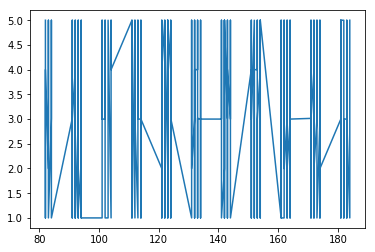

In [6]:
plt.plot(X['timesteps'], y)

In [ ]:
limit_fit = Pipeline([
    ('limit', ColumnSelector(name='limit')),
    ('limit_spline', LinearSpline(knots=[2500, 6000, 7000]))
])